In [2]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import photontorch as pt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from photontorch.environment import current_environment
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
import pandas as pd 
from photontorch import BoundedParameter
from ipywidgets import interact
from tqdm.notebook import trange
import warnings
warnings.filterwarnings("ignore")
torch.__version__

'1.6.0'

### Components: PD, MZ Intensity Modulator, Electronic combiner, Optical Attenuator, Readout, CW Laser

In [3]:
class attenuator(pt.Component):
    """
    The optical attenuator is a 2 port component that attenuates the signal. It is bounded from 0 to 1.
    The attenuation is trainable.
    
    Terms: 
    Optical  0 ----- 1  Optical
            
    """      
    num_ports = 2
    
    def __init__(
    self,
    trainable = True,
    attenuation = 0.0,
    name=None,
    ): 
        #self.attenuation = float(attenuation)
        super(attenuator, self).__init__(name=name)
        if trainable:
            self.attenuation = BoundedParameter(
            data=torch.tensor(attenuation, device=self.device),
            bounds=(0.0, 1.0),
            requires_grad=True,
            )
        else:
            self.attenuation = pt.Buffer(
            data=torch.tensor(attenuation, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,0,1] = S[0,:,1,0] = (1.0-self.attenuation) ** 0.5

        return S

In [4]:
class cw_laser(pt.Component):
    """
    A CW Laser used when multiple sources are desired in a network. Note: When linking, terminate the component's 
    0 port.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        Power = 1,  #Input the laser power here
        delay=0,
        name = None,  
        ):
        
        super(cw_laser,self).__init__(name=name) 
        self.Power = float(Power)
        self.delay = float(delay)
            
    def action(self, t, x_in, x_out):
        #Input port actions
        a_in, _ = x_in
        x_out[0] = a_in  #Nothing happens to input node
        
        if t<self.delay:
            x_out[1,0] = 0.0001  #Zero noise floor
        else:
            x_out[1,0] = self.Power ** 0.5
        
        x_out[1,1] = 0  #no phase information, this is a real source
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [5]:
class mask(pt.Component):
    """
    A masking signal that is either binary or from a standard distribution.

    Terms: 
        0 ---- 1 
    
    """       
    num_ports = 2
    
    def __init__(
        self,
        m_length = 5,
        mask_vector=torch.ones(5),
        name=None,
    ):
        
        super(mask,self).__init__(name=name)
        self.m_length = int(m_length)
        self.mask_vector = mask_vector
        self.counter = -1
        
        #print(x)
        
        
    def action(self,t,x_in,x_out):
        a_in, _ = x_in
        
        x_out[0] = a_in  #Nothing happens to input node        
        
        self.counter = self.counter + 1
            
        x_out[1] = a_in * self.mask_vector[self.counter]
        #print(x_out[1])
        if self.counter == self.m_length-1:
            self.counter = -1
            
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self,S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

### Constructing the Reservoir Circuit

In [15]:
class dc_reservoir(pt.Network):
    def __init__(self, attenuation=0.1, wg_delay=1e-9, wg_phase=0, tr=0.9, loss=20,
                 nodes=25, mask_vector=torch.ones(10, dtype=torch.float64), 
                 weights = 0.1*torch.rand(25, dtype=torch.float64),
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, mzi_fb=1e-3):
        super(dc_reservoir, self).__init__()
        
        self.src = pt.Source()
        self.det = pt.Detector()
        self.mask = mask(m_length=nodes, mask_vector = mask_vector)
        self.att = attenuator(attenuation=attenuation, trainable = False) 
        self.term = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff = neff,loss=loss, phase=wg_phase)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff = neff,loss=loss)
        self.fb = pt.Waveguide(neff = neff, ng=ng, length=mzi_fb, loss=loss)
        self.link('src:0', '0:mask:1', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('dc2:2', '0:wg2:1', '0:att:1', '3:dc1')
        self.link('dc2:3', '0:fb:1', '2:dc1')
        #print(self.graph(draw=True))
        #print(length-mzi_l2)

print(torch.where(dc_reservoir().free_ports_at)[0])


tensor([], dtype=torch.int64)


In [16]:
class dc_reservoir_freq(pt.Network):
    def __init__(self, wg_delay=1e-9, wg_phase=0, tr=0.9,
                 neff = 2.2111, ng = 2.2637, mzi_l1=1e-3, mzi_l2=1e-3, mzi_fb=1e-3, loss=20):
        super(dc_reservoir_freq, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.term = pt.Term()
        self.dc1 = self.dc2 = pt.DirectionalCoupler(1-tr)
        self.wg1 = pt.Waveguide(length=mzi_l1, ng = ng, neff=neff, loss=loss, phase=wg_phase)
        self.wg2 = pt.Waveguide(length=mzi_l2, ng = ng, neff=neff, loss=loss)
        self.fb = pt.Waveguide(ng=ng, neff=neff, length=mzi_fb, loss=loss)
        self.link('src:0', '0:dc1:1', '0:wg1:1', '0:dc2:1', '0:det')
        self.link('dc2:2', '0:wg2:1', '3:dc1')
        self.link('dc2:3', '0:fb:1', '2:dc1')
        #print(self.graph(draw=True))

## Simulation Setup

In [17]:
'''------- Generate uniform distribution between 0 and 0.5 -------'''

class Narma10Generator(np.random.RandomState):
    def __call__(self, N, B=1):
        u = (0.5-0)*self.rand(N,B)
        return u

In [18]:
'''----- NARMA10 TASK -----'''

def narma10_jaeger(x):
    
    size = len(x)
    y = torch.zeros(x.shape)
    for n in range(10,size):
        y[n] = 0.3*y[n-1] + 0.05*y[n-1]*(y[n-1]+y[n-2]+y[n-3] \
            +y[n-4]+y[n-5]+y[n-6]+y[n-7]+y[n-8]+y[n-9]+y[n-10]) \
            + 1.5*x[n-10]*x[n-1] + 0.1
    return y



In [19]:
'''----- MEMORY CAPACITY TASK -----'''

class mem_cap_Generator(np.random.RandomState):
    def __call__(self, N, B=1):
        z = self.rand(N,B)
        return z
    
def COPY(bits):
    return bits.copy()

def Delay(x, bits):
    arr=np.concatenate([trbits,np.zeros_like(trbits[:x])])
    if x == 0:
        arr=arr
    else:
        arr=np.delete(arr, np.s_[:x])
    return arr

TARGET = COPY

In [20]:
'''----- SIMULATION PARAMETERS -----'''

# ----- General Parameters -----
c = 299792458.0                           #[m/s] speed of light
Rb = 1e9                                  #[1/s] bitrate
Rs = 50*Rb                                #[1/s] samplerate
fc = 10e9                                  #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9                             #[m] center wavelength
neff = 2.2111     #1.4440                 #[1] effective index of fiber spool
ng = 2.2637       #1.4626                 #[1] group index of fiber spool
neff_mzm = 2.2111                         #[1] Effective index of lithium niobate (modulator)
ng_mzm = 2.2637                           #[1] Group index of lithium niobate (modulator)
N = 500                                  #[1] number of bits per bit stream
B = 1                                     #[1] Number of bit streams in training batch
sim_time = N/Rb                           #[s] Simulation time 
wl = 1.55e-6                              #[m] Center Wavelength
Str, Sva, Ste = (10, 2, 3)                #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng)                      #[m] reference length (distance a bit travels during one bit period)
device = torch.device("cpu")              #default device used
torch.set_default_dtype(torch.float32)    #default dtype used
torch.manual_seed(3)                      #pytorch seed
np.random.seed(42)                        #numpy seed


# ----- Reservoir Parameters -----
las_pow = 1                               #[1] Laser Power
wg_delay = 1.0e-9 #equivalent to k=1      #[s] Delay tao(Along with group index below)
fb_att = 0.1                              #[1] Feedback attenuation (strength)
fb_phase=0                                #[1] Feedback phase
Nodes = np.int(Rs/Rb)                     #[1] Number of virtual nodes in the reservoir
print(Nodes)
mask_vector = 0.2*torch.rand(Nodes)       #Input mask

50


In [21]:
'''----- BITSTREAM GENERATION -----'''
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)

In [22]:
'''----- BITSTREAMS -----'''
delay=20
# train streams
trbits = mem_cap_Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
trbits_delay = Delay(x=delay,bits=trbits).reshape(N,1)
trstream = streamgen(trbits_delay)
trtarget = streamgen(trbits)
trtarget_np = trtarget.numpy()
#print(np.size(trbits_delay))
#print(np.shape(trbits_delay))
#print(trbits_delay)
# validation streams
#vabits = Narma10Generator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
#vastream = streamgen(vabits)
#vatarget = streamgen(TARGET(vabits))

# Simulation time tensor
t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)

In [23]:
'''----- Mean Squared Error Function -----'''
def mse_new(target,predicted,Bits):
    mse = 0
    for i in range(target.size):
        mse = mse+(target[i] - predicted[i])**2
    mse = mse/Bits
    return mse

## Frequency Domain Response


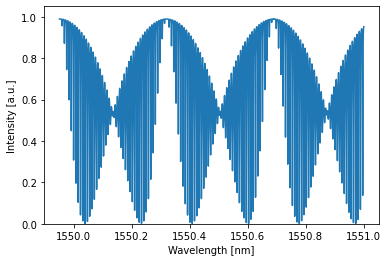

In [26]:
wavelengths = 1e-9*np.linspace(1549.95,1551,10000)
freq_env = pt.Environment(wl=wavelengths, freqdomain=True)
wg_phase_=0
tr_=0.5
wg_delay_=1.02e-9
wl0_=1.55e-6
Bits=N
mzi_l1 = 1e-3
mzi_l2 = 13.12e-2
mzi_fb = 3.88e-3
loss= 20

ring_res_freqtest = dc_reservoir_freq(wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, mzi_fb=mzi_fb, loss=loss)


with freq_env:
    detected_freq = ring_res_freqtest(source=1)
    
ring_res_freqtest.plot(detected_freq)
#mpl.rcParams['font.family'] = 'Avenir'
#plt.rcParams['font.size'] = 12
#plt.rcParams['axes.linewidth'] = 1
#plt.xlim(1549.5e3, 1550.7e-3)
plt.ylim(0, 1.05)
plt.show()
    

In [27]:
#Export to be plotted in MATLAB

detected_freq_np = detected_freq.numpy().reshape([10000,1])
det_data = pd.DataFrame(detected_freq_np)
det_data.to_csv('det_freq.csv')

## Training for Memory Capacity

In [29]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
bit_length=299792458*wg_delay_/ng
wl0_=1.55e-6
wl0_va = 1.55e-6
Bits=N
mask_vector = 0.5*torch.rand(Nodes)       #Input mask
mzi_l1 = 1e-3
mzi_l2 = 13.12e-2#13.12e-2
#mzi_fb = bit_length - mzi_l2
mzi_fb = 3.88e-3
loss=20

for i in range(16):
    
    total_mc=0  #initialize sum of memory capacity
    
    wg_phase_=i*(1/8)*np.pi

    ring_res_test = dc_reservoir(attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, mzi_fb=mzi_fb, loss=loss)


    for i in range(1,Nodes+1):
        trbits = mem_cap_Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
        trbits_delay = Delay(x=i,bits=trbits).reshape(N,1)
        trstream = streamgen(trbits_delay)
        trtarget = streamgen(trbits)
        trtarget_np = trtarget.numpy()
        t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)
    
        with pt.Environment(t=t, wl0=wl0_, num_wl=1):
            detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        
        #Data preparation -- Removing the first 200 bits
        detected_np = detected.numpy()
        detected_np = detected_np.reshape(Bits,Nodes)
        target_now = TARGET(trbits)
        detected_np_cut = detected_np[100:,:]
        target_now_cut = target_now[100:]
        
        #Regression and Prediction
        regr = linear_model.LinearRegression()
        x = regr.fit(detected_np_cut,target_now_cut)
        y = regr.predict(detected_np_cut)
        
        #Error Calculation
        mc = regr.score(detected_np_cut,target_now_cut)
        if mc<0:
            mc=0
        #print(mc)
        #mse = mse_new(target_now_cut,y,Bits)
        total_mc = total_mc + mc
#plt.plot(y,label='Predicted')
#plt.plot(target_now_cut,label='Target')
#plt.legend(loc='upper right')
#plt.xlabel('Sample')
#plt.ylabel('Power')
#plt.xlim(0,30)
#plt.show()

    print(f'phase: {wg_phase_}, total memory capacity: {total_mc}')            

phase: 0.0, total memory capacity: 13.855203689072846
phase: 0.39269908169872414, total memory capacity: 14.611054253532053
phase: 0.7853981633974483, total memory capacity: 15.450958212205448
phase: 1.1780972450961724, total memory capacity: 17.623761257572102
phase: 1.5707963267948966, total memory capacity: 17.86925290469168
phase: 1.9634954084936207, total memory capacity: 18.023029779209672
phase: 2.356194490192345, total memory capacity: 18.08495906347243
phase: 2.748893571891069, total memory capacity: 15.389364633655642
phase: 3.141592653589793, total memory capacity: 16.07177430886823
phase: 3.5342917352885173, total memory capacity: 11.569441884650951
phase: 3.9269908169872414, total memory capacity: 15.05829474990026
phase: 4.319689898685965, total memory capacity: 16.979353809987302
phase: 4.71238898038469, total memory capacity: 17.552458999570256
phase: 5.105088062083414, total memory capacity: 16.931471233497394
phase: 5.497787143782138, total memory capacity: 14.9380119

In [246]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
bit_length=299792458*wg_delay_/ng
wl0_=1.55e-6
wl0_va = 1.55e-6
Bits=N
mask_vector = 0.5*torch.rand(Nodes)       #Input mask
mzi_l1 = 13.12e-2
mzi_l2 = 2e-3#13.12e-2
#mzi_fb = bit_length - mzi_l2
mzi_fb = bit_length-mzi_l2
loss=20

for i in range(1,16):
    
    total_mc=0  #initialize sum of memory capacity
    
    wg_phase_=i*(1/8)*np.pi

    ring_res_test = dc_reservoir(attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, mzi_fb=mzi_fb, loss=loss)


    for i in range(1,Nodes+1):
        trbits = mem_cap_Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
        trbits_delay = Delay(x=i,bits=trbits).reshape(N,1)
        trstream = streamgen(trbits_delay)
        trtarget = streamgen(trbits)
        trtarget_np = trtarget.numpy()
        t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)
    
        with pt.Environment(t=t, wl0=wl0_, num_wl=1):
            detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        
        #Data preparation -- Removing the first 200 bits
        detected_np = detected.numpy()
        detected_np = detected_np.reshape(Bits,Nodes)
        target_now = TARGET(trbits)
        detected_np_cut = detected_np[100:,:]
        target_now_cut = target_now[100:]
        
        #Regression and Prediction
        regr = linear_model.LinearRegression()
        x = regr.fit(detected_np_cut,target_now_cut)
        y = regr.predict(detected_np_cut)
        
        #Error Calculation
        mc = regr.score(detected_np_cut,target_now_cut)
        if mc<0:
            mc = 0
        print(mc)
        #mse = mse_new(target_now_cut,y,Bits)
        total_mc = total_mc + mc
#plt.plot(y,label='Predicted')
#plt.plot(target_now_cut,label='Target')
#plt.legend(loc='upper right')
#plt.xlabel('Sample')
#plt.ylabel('Power')
#plt.xlim(0,30)
#plt.show()

    print(f'phase: {wg_phase_}, total memory capacity: {total_mc}')            

0.967243160328539
0.9673507252082454
0.9645233704204595
0.9393852916707689
0.909254916004696
0.7738929661713005
0.8380357911606752
0.5627120638213934
0.4679581753261627
0.6223210102863751
0.49222285932016974
0.45331569257619575
0.32304099122738617
0.3608667245096565
0.23494032242474505
0.3802369952573571
0.38921584659320974
0.3822404077856818
0.28025592130003596
0.26807005261977934
0
0.1762966337477584
0
0
0.07101342131341204
0.14956811303249273
0
0
0.12465433377679991
0.10242172692972706
0.06626912502804072
0
0.07612051298202427
0.07860145874988445
0.006209233094470745
0.03323603746797699
0.062169144174086366
0
0.12074444856298872
0
0.10892602171836907
0.11467690221305882
0
0.1408161595744466
0.12709117803480086
0
0.026184141569824293
0.08284119984593186
0.05431484840934231
0.07943605871578852
phase: 3.141592653589793, total memory capacity: 13.37867398295406
0.9731321371080035
0.9690117883660053


KeyboardInterrupt: 

In [ ]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
bit_length=299792458*wg_delay_/ng
wl0_=1.55e-6
wl0_va = 1.55e-6
Bits=N
mask_vector = 0.5*torch.rand(Nodes)       #Input mask
mzi_l1 = 1e-3
mzi_l2 = 1.1e-3
#mzi_fb = bit_length - mzi_l2
mzi_fb = 1e-3
loss=20

for i in range(1,8):
    
    total_mc=0  #initialize sum of memory capacity
    
    wg_phase_=i*(1/4)*np.pi

    ring_res_test = dc_reservoir(attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, loss=loss)


    for i in range(1,Nodes+1):
        trbits = mem_cap_Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
        trbits_delay = Delay(x=i,bits=trbits).reshape(N,1)
        trstream = streamgen(trbits_delay)
        trtarget = streamgen(trbits)
        trtarget_np = trtarget.numpy()
        t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)
    
        with pt.Environment(t=t, wl0=wl0_, num_wl=1):
            detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        
        #Data preparation -- Removing the first 200 bits
        detected_np = detected.numpy()
        detected_np = detected_np.reshape(Bits,Nodes)
        target_now = TARGET(trbits)
        detected_np_cut = detected_np[100:,:]
        target_now_cut = target_now[100:]
        
        #Regression and Prediction
        regr = linear_model.LinearRegression()
        x = regr.fit(detected_np_cut,target_now_cut)
        y = regr.predict(detected_np_cut)
        
        #Error Calculation
        mc = regr.score(detected_np_cut,target_now_cut)
        print(mc)
        #mse = mse_new(target_now_cut,y,Bits)
        total_mc = total_mc + mc
#plt.plot(y,label='Predicted')
#plt.plot(target_now_cut,label='Target')
#plt.legend(loc='upper right')
#plt.xlabel('Sample')
#plt.ylabel('Power')
#plt.xlim(0,30)
#plt.show()

    print(f'phase: {wg_phase_}, total memory capacity: {total_mc}')

In [137]:
'''----- Training -----'''
torch.manual_seed(5)                      #pytorch seed
tr_=0.5
fb_att_=0
wg_delay_=1.02e-9
wl0_=1.5501614e-6
wl0_va = 1.550161401e-6
Bits=N
mask_vector = 0.5*torch.rand(Nodes)       #Input mask
mzi_l1 = 1e-3
mzi_l2 = 1.1e-3
mzi_fb = 1e-3
loss=20

for i in range(1,101):
    
    total_mc=0  #initialize sum of memory capacity
    
    wg_phase_=0.01*i*np.pi

    ring_res_test = dc_reservoir(attenuation=fb_att_, wg_delay=wg_delay_, wg_phase=wg_phase_, 
                            ng=ng, tr=tr_, neff=neff, mask_vector=mask_vector, nodes=Nodes, mzi_l1=mzi_l1,
                            mzi_l2 = mzi_l2, loss=loss)


    for i in range(1,Nodes+1):
        trbits = mem_cap_Generator(seed=Str)(N, 1) # N bits per train stream, B train streams per batch.
        trbits_delay = Delay(x=i,bits=trbits).reshape(N,1)
        trstream = streamgen(trbits_delay)
        trtarget = streamgen(trbits)
        trtarget_np = trtarget.numpy()
        t = np.arange(trstream.shape[0], dtype=np.float32)*(1/Rs)
    
        with pt.Environment(t=t, wl0=wl0_, num_wl=1):
            detected = ring_res_test(source=trstream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
        
        #Data preparation -- Removing the first 200 bits
        detected_np = detected.numpy()
        detected_np = detected_np.reshape(Bits,Nodes)
        target_now = TARGET(trbits)
        detected_np_cut = detected_np[100:,:]
        target_now_cut = target_now[100:]
        
        #Regression and Prediction
        regr = linear_model.LinearRegression()
        x = regr.fit(detected_np_cut,target_now_cut)
        y = regr.predict(detected_np_cut)
        
        #Error Calculation
        mc = regr.score(detected_np_cut,target_now_cut)
        #mse = mse_new(target_now_cut,y,Bits)
        total_mc = total_mc + mc
#plt.plot(y,label='Predicted')
#plt.plot(target_now_cut,label='Target')
#plt.legend(loc='upper right')
#plt.xlabel('Sample')
#plt.ylabel('Power')
#plt.xlim(0,30)
#plt.show()

    print(f'phase: {wg_phase_}, total memory capacity: {total_mc}')            

phase: 0.031415926535897934, total memory capacity: 3.2705213630781116
phase: 0.06283185307179587, total memory capacity: 3.2512078472498267
phase: 0.09424777960769379, total memory capacity: 3.240227953263916
phase: 0.12566370614359174, total memory capacity: 3.2401348065805924
phase: 0.15707963267948966, total memory capacity: 3.2487370534120616
phase: 0.18849555921538758, total memory capacity: 3.2615467905898488
phase: 0.21991148575128555, total memory capacity: 3.2771778470063224
phase: 0.25132741228718347, total memory capacity: 3.2979779466765513
phase: 0.2827433388230814, total memory capacity: 3.3249798473145504
phase: 0.3141592653589793, total memory capacity: 3.350673383788396
phase: 0.34557519189487723, total memory capacity: 3.364246910687218
phase: 0.37699111843077515, total memory capacity: 3.3633630569947552
phase: 0.4084070449666731, total memory capacity: 3.351582499283321


KeyboardInterrupt: 

length=299792458*wg_delay_/ng
print(length-3.88e-3)
fsr = 1550e-9**2/(ng*length)
fsr2 = 1550e-9**2/(ng*5.88e-3)
print(f'fsr of long loop: {fsr}, fsr of short loop: {fsr2}')